# Pre - Training the model

## Load Tokenizer

In [1]:
import sys
sys.path.append('..')

In [2]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file = '../output/tokenizer/my_tokenizer.model')

In [3]:
def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

get_vocab_size(tokenizer)

1033

## Create the language model

In [4]:
import torch
torch.manual_seed(66)

In [5]:
from transformer.model import GPTLanguageModel

block_size = 512  # seq len
n_embed = 128
n_head = 8
n_layer = 1
dropout = 0.2
batch_size = 128
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size = vocab_size,
    block_size = block_size,
    n_embed = n_embed,
    n_head = n_head,
    n_layer = n_layer,
    dropout=dropout,
    device=device
).to(device)

# commenting out because triton is not fully supported for windows
# this is a powerful feature that tries to speed up the model by useing a backend compiler, but it relied on Triton library
# model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.529161 M parameters


## Data Preparation

##### 1. Load Dataset

Encoding the dataset

In [6]:
with open('../output/combined_text.txt', 'r', encoding='utf-8') as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

446516

##### 2. Split Dataset

In [7]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)

split_index = int(0.9 * len(data))

train_data = data[:split_index]
val_data = data[split_index:]

##### 3. Data Loader

Creating our dataset loader using Dataset (Recipe) and DataLoader (Chef)

In [8]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index + self.block_size]
        y = self.data[index + 1: index + self.block_size + 1]  # cos of how we split the data
        return x, y
    

def get_dataloaders(
        train_data: torch.Tensor,
        val_data: torch.Tensor,
        block_size: int,
        batch_size: int,
        device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    
    # get the dataset
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    # now create their data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [9]:
train_loader, val_loader = get_dataloaders(
    train_data=train_data, val_data=val_data, 
    block_size=block_size, batch_size=batch_size,
    device=device)

# fetches one single batch of training data
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 512]), torch.Size([128, 512]))

## Training

In [10]:
from typing import Dict

# gradient is calculated only during training. we turn it off cos its computationally expensive
@torch.no_grad
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)

        for i, (x, y) in enumerate(loader):

            # set set eval_iters cos we dont wanna go through all the batches in the validation dataset as it will only slow down the training process
            # so we just use some sample batches from validation data
            # if you want to eval on batches then comment out the if statement.
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
                losses[i] = loss.item()
        output[split] = losses.mean().item()

    # setting it to train again cos we will resume training after eval
    model.train()
    return output

In [11]:
def save_checkpoint(
        model: GPTLanguageModel,
        optimizer: torch.optim.Optimizer,
        epoch: int,
        loss: float,
        file_path: str = 'checkpoint.pth'
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }

    torch.save(checkpoint, file_path)

In [ ]:

# PILOT TESTING HYPERPARAMS
max_iters = 1  # epochs
eval_interval = 100  # evaluate every 100 epochs
eval_iters = 200
learning_rate = 1e-4

# TRAIN HYPERPARAMS
# max_iters = 100  # epochs
# eval_interval = 10  # evaluate every 10 epochs
# eval_iters = 200
# learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

# keeping track so we can plot them
train_losses = []
val_losses = []

for iteration in range(max_iters):  # epochs

    # inside the epoch, this loop feeds the model data in batches.
    # will run until every batch in train_loader has been processed
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

        # Stop and evaluates after every eval_interval no. of batches
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) -1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )

            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"Epoch {iteration} / step {batch_idx}: "
                f"train loss {losses['train']: .4f}, "
                f"val loss {losses['val']: .4f}"
            )

        # train model
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)  # compute the gradients
        loss.backward()  # backpropagation: calc gradient for every learnable parameter in the model. gives direction & qty to adjust
        optimizer.step()  # updates the weights accordingly

    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path= f'../output/pre-training/run_1/checkpoint_{iteration}.pth'
    )

## Training Metrics

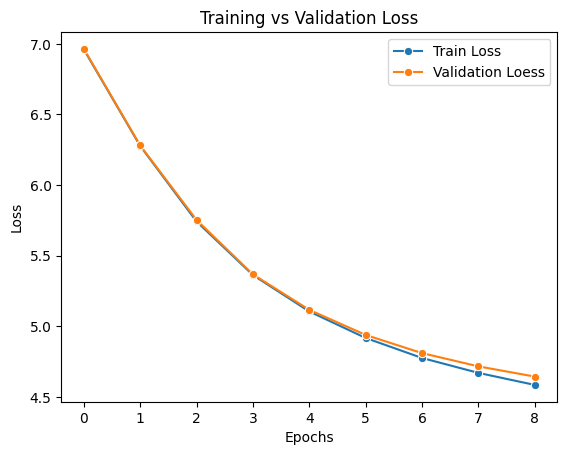

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs = list(range(0, len(train_losses)))


sns.lineplot(x=epochs, y=train_losses, label='Train Loss', marker='o')
sns.lineplot(x=epochs, y=val_losses, label='Validation Loess', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

## Testing the model

We add the extra dimension to the tensor cos even if it's a single sequence, we need to add the 'batch' dimension.  
initial shape: `[sequence length]` - 1D vector holding the data    
new shape: `[1, sequence_length]`

In [ ]:
input_tokens = tokenizer.encode('Hello')

# creating tensor
input_tokens = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=256)

print(tokenizer.decode(output[0].tolist()))